In [1]:
# import clustering method
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn import metrics
from tqdm.notebook import tqdm
from PIL import Image

# import torch, cv2 and other dependencies
from torchvision import datasets, transforms
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.models import resnet101

import os
import cv2
import pickle
import logging
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import math

In [2]:
# set random seed
import random
random.seed(33)
np.random.seed(33)

# Create BDD100k dataset loader

In [3]:
class BDD100kDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        dataroot,
        image_set="train",
        transform=transforms.Compose([transforms.Resize((384, 384)), 
                                      transforms.ToTensor(),
                                      transforms.Normalize(0.5, 0.5),
                                      ]),
        is_test=False,
        keep_difficult=False,
        label_file=None,
        version='100k',
        split='train'
    ):
        """Dataset for BDD100k data.
        Args:
            dataroot: the root of the BDD100k dataset, 
        """
        self.dataroot = dataroot
        self.transform = transform
        self.version = version
        self.split = split
        self.filenames, self.tokens = [], []
        
        if self.version in ['10k', '100k']: 
            self.dataroot = os.path.join(self.dataroot, self.version, self.split)
        else:
            assert self.version in ['10k','100k']
            print('Please use either 10k samples version or 100k full dataset')
        
        #pbar = tqdm(enumerate(os.listdir(self.dataroot)))
        #for filename in os.listdir(self.data_dir):
        img_list = os.listdir(self.dataroot)
        for idx, filename in enumerate(tqdm(img_list)):
            img_path = os.path.join(self.dataroot, filename)
            self.filenames.append(img_path)
            self.tokens.append(img_path.split('/')[-1].split('.')[0])
            
        print('Number of data samples in the set: {}'.format(len(self.filenames)))

    # method to get length of data
    def __len__(self):
        return len(self.filenames)

    # method to get a sample
    def __getitem__(self, idx, transform=True):
        # get image
        image_filename = self.filenames[idx]
        image = Image.open(image_filename).convert('RGB')
        # transform image
        image = self.transform(image) if transform else image
        # get token
        token = self.tokens[idx]
        # return image
        return {'image': image, 'token': token}


In [4]:
# Provide link to the dataset
dataroot = ''
version='100k'
split='train'
dataset = BDD100kDataset(dataroot=dataroot, 
                         version=version, 
                         split=split,
                         transform=lambda x: x)

  0%|          | 0/70000 [00:00<?, ?it/s]

Number of data samples in the set: 70000


(1280, 720)


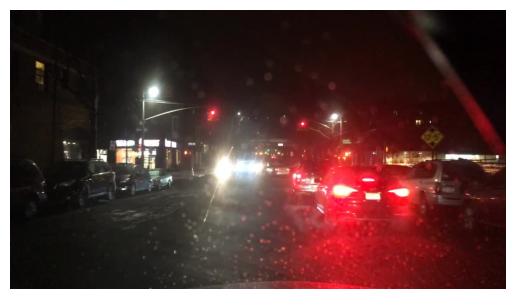

In [5]:
sample = dataset[0]
print(sample['image'].size)
plt.imshow(sample['image'])
plt.axis('off')
plt.show()

In [6]:
dataset = BDD100kDataset(dataroot=dataroot, 
                         version=version, 
                         split=split)

  0%|          | 0/48156 [00:00<?, ?it/s]

Number of data samples in the set: 48156


# Define paths and dataset

In [6]:
# Provide path to store the features and cluster info
DEV_ROOT = ''
dataset_str='bdd100k'
train_features_fname = os.path.join(DEV_ROOT, f'{dataset_str}_training_features.pkl')
train_cluster_info_fname = os.path.join(DEV_ROOT, f'{dataset_str}_training_cluster_info.pkl')

# Compute features from raw dataset

In [9]:
if not os.path.exists(train_features_fname):
    # use a pre-trained model to get the feature vectors for all the images
    # in the dataset
    model = resnet101(pretrained=True, progress=True)
    # remove the last layer keeping the weights
    model = torch.nn.Sequential(*list(model.children())[:-1])

    model.eval()
    model.cuda()
    train_tokens, train_features = [], []
    with torch.no_grad():
        for i in tqdm(range(len(dataset))):
            img = dataset[i]['image'].unsqueeze(0).cuda()
            # inference
            feature = model(img).flatten().cpu().numpy()
            train_features.append(feature)
            train_tokens.append(dataset[i]['token'])
    train_features = np.array(train_features)
    # save the features to disk as a pickle file
    with open(train_features_fname, 'wb') as f:
        pickle.dump({'tokens': train_tokens, 'features': train_features}, f)

# Compute clusters in a lower-dimensional space for training dataset

In [ ]:
# load the training features from disk
data = pickle.load(open(train_features_fname, 'rb'))
train_tokens, train_features = \
    data['tokens'], data['features']

# project the features onto a 2D t-SNE plot
print('Projecting training dataset features to 2D...')

num_dimensions = 3
learning_rate= 1
num_images = len(dataset)
verbose = 2
n_iteraions = 500
random_num = int(random.random())        

# tsne = TSNE(n_components=num_dimensions, 
#             learning_rate = learning_rate,
#             perplexity=round(math.sqrt(num_images)),
#             random_state = random_num,
#             verbose=verbose, 
#             n_iter=n_iteraions)
tsne = TSNE(n_components=num_dimensions, verbose=verbose, perplexity=50, n_iter=n_iteraions)
tsne_results = tsne.fit_transform(train_features)
# find clusters using DBSCAN

db = DBSCAN(eps=1.5, min_samples=100).fit(tsne_results)
print('Number of clusters: {}'.format(len(np.unique(db.labels_))))
labels = db.labels_

# visualize the clusters
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(tsne_results[:,0], tsne_results[:,1], tsne_results[:,2], c=labels, cmap='inferno')
ax.scatter(tsne_results[:,0], tsne_results[:,1], c=labels, cmap='inferno')
plt.axis('off')

plt.savefig(os.path.join(DEV_ROOT, f'{dataset_str}_training_clusters_50k.png'), bbox_inches='tight', pad_inches=0)
plt.show()

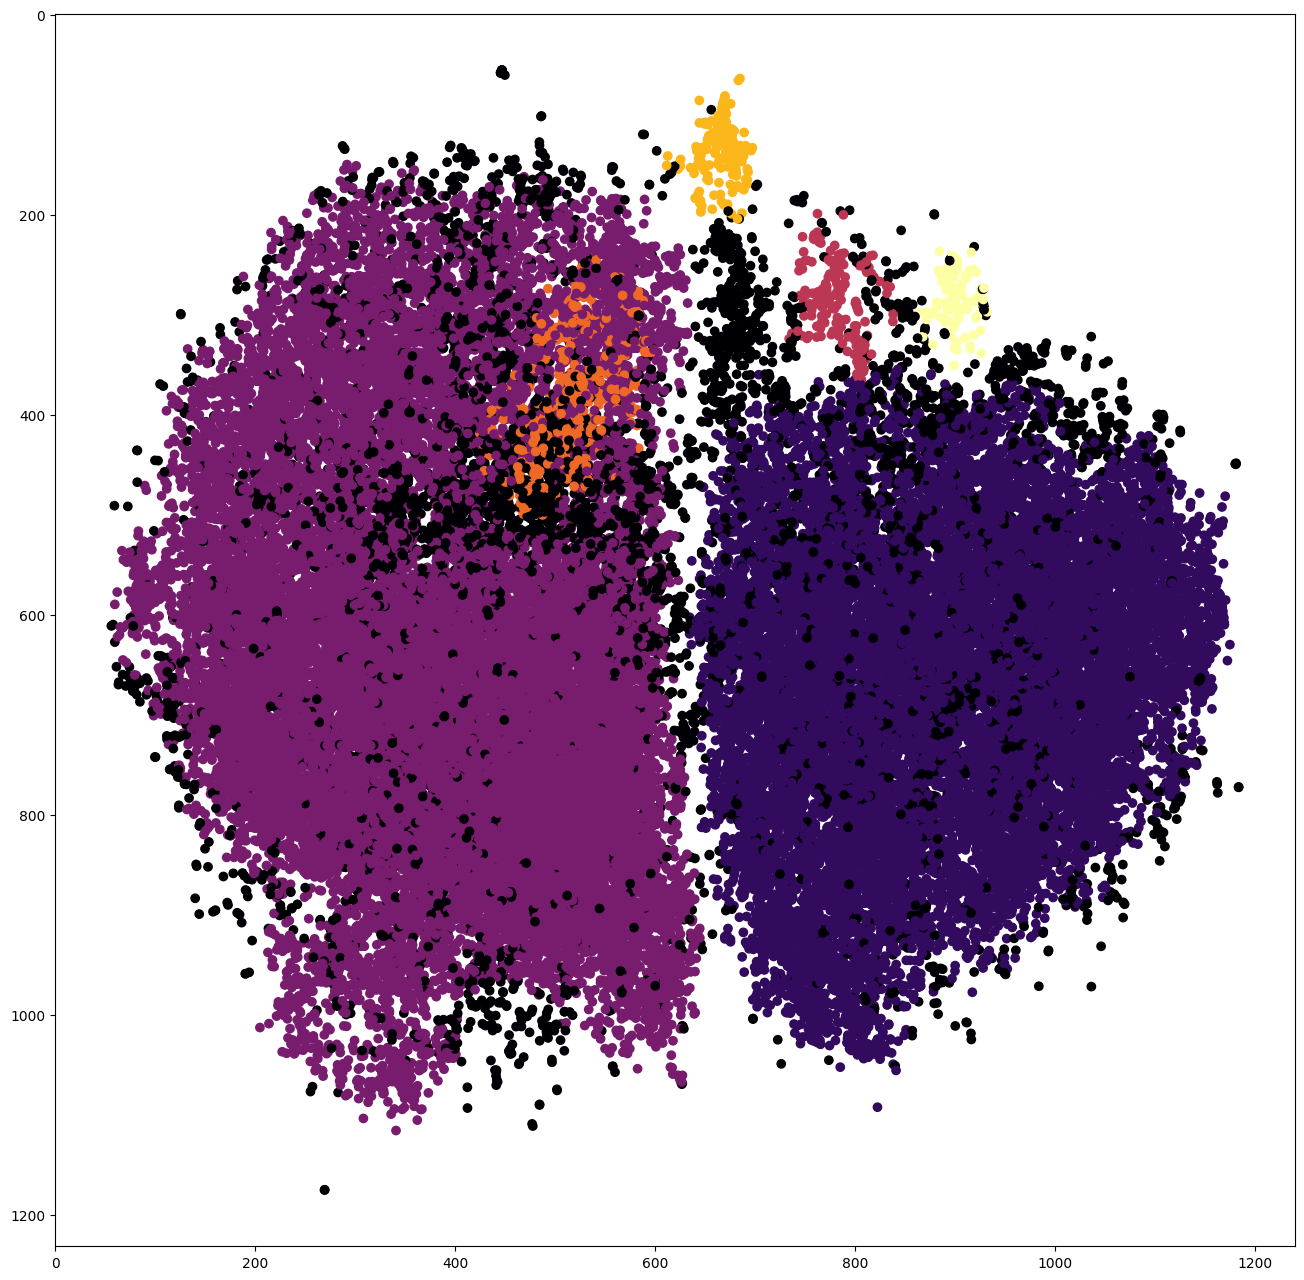

In [10]:
# %matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread(os.path.join(DEV_ROOT, f'{dataset_str}_training_clusters_50k.png'))
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)
imgplot = plt.imshow(img)
plt.show()

In [11]:
# sort clusters in the order of most common to rare
unique_cluster_ids = np.unique(labels)
cluster_sizes = {cl_id: np.sum(labels == cl_id) for cl_id in unique_cluster_ids}
unique_cluster_ids = sorted(unique_cluster_ids, key=lambda i: cluster_sizes[i])
largest_cluster_size = cluster_sizes[unique_cluster_ids[-1]]

In [ ]:
# get the cluster id and cluster size for each image
train_dataset_cluster_info = {}
for i in range(len(train_tokens)):
    cluster_info = {'cluster_id': labels[i], 
                    'cluster_size': np.sum(labels == labels[i]), 
                    'largest_cluster_size': largest_cluster_size}
    train_dataset_cluster_info[train_tokens[i]] = cluster_info
# save the cluster info to disk
with open(train_cluster_info_fname, 'wb') as f:
    pickle.dump(train_dataset_cluster_info, f)
    print('Saved training cluster info to {}'.format(train_cluster_info_fname))

In [13]:
# load cluster info from disk
train_dataset_cluster_info = pickle.load(open(train_cluster_info_fname, 'rb'))

# Show stats about clusters

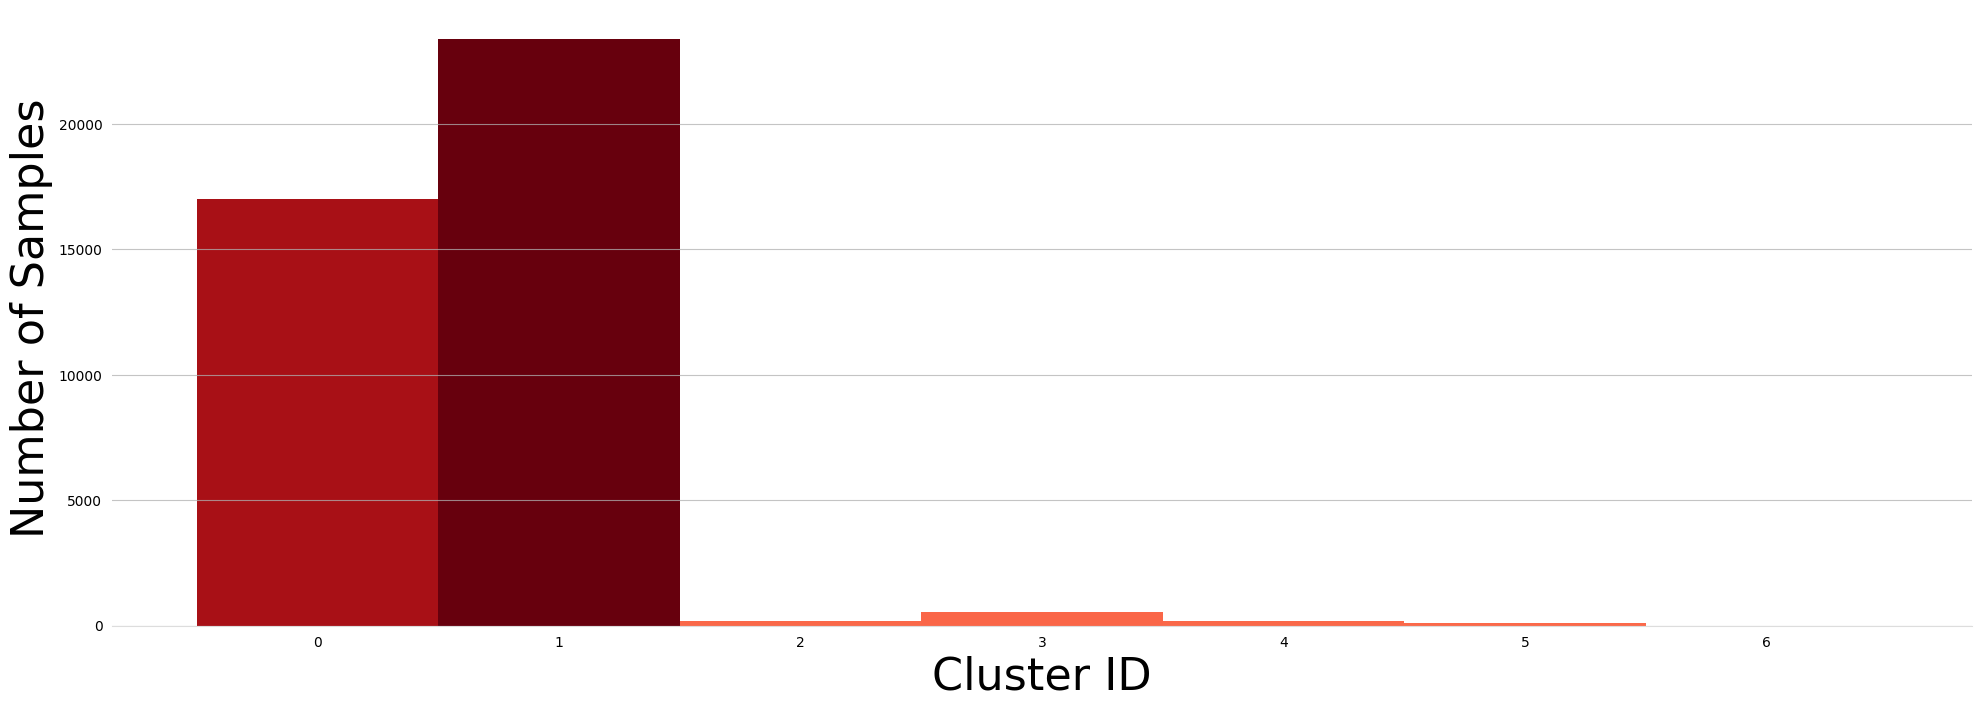

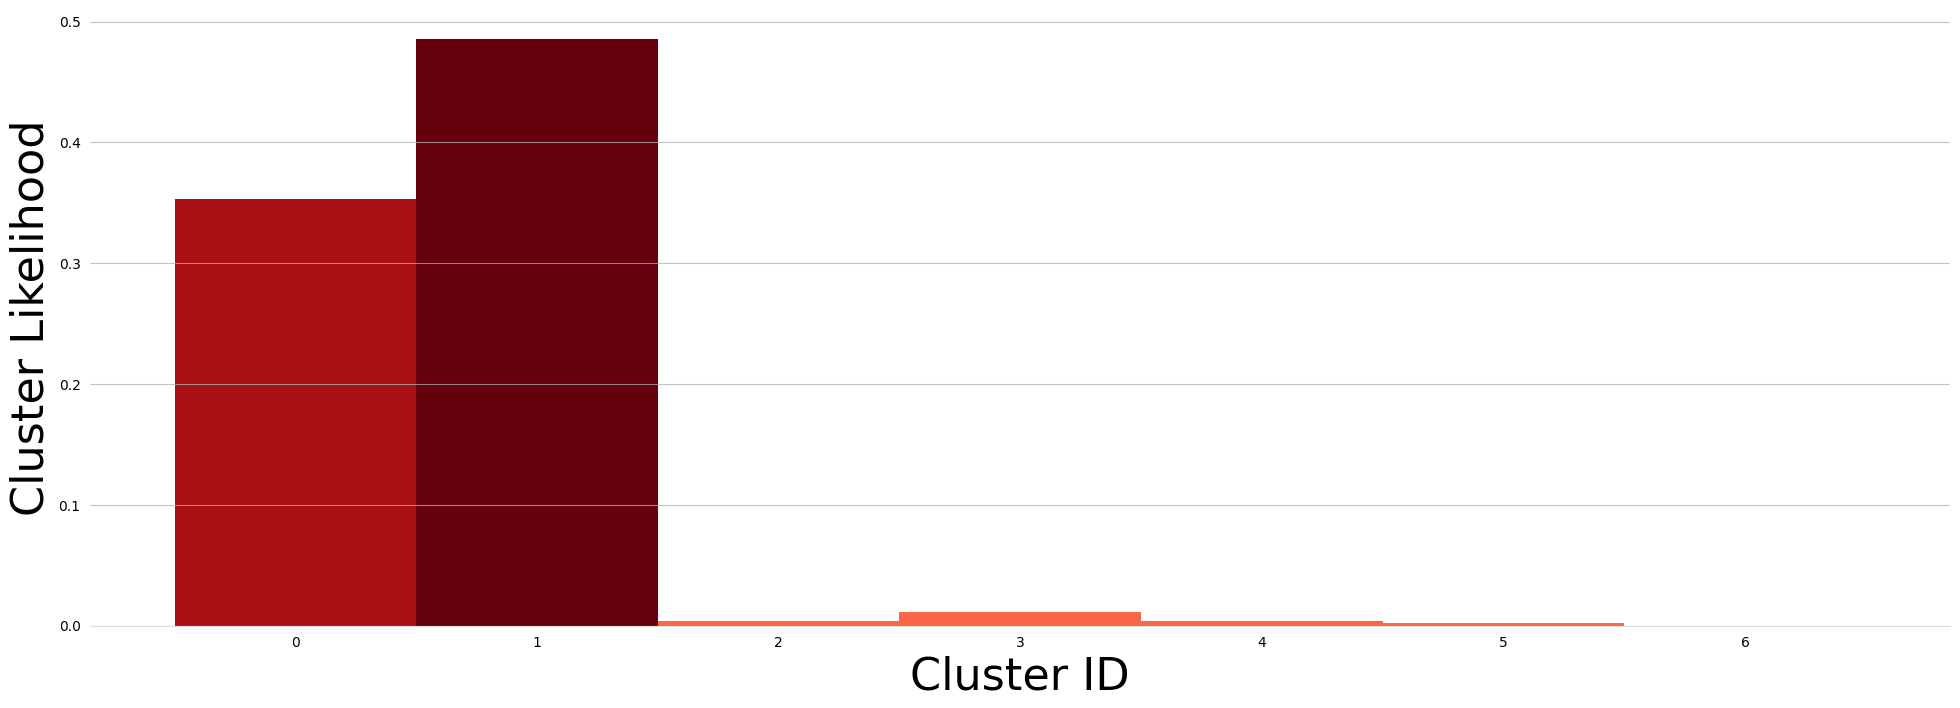

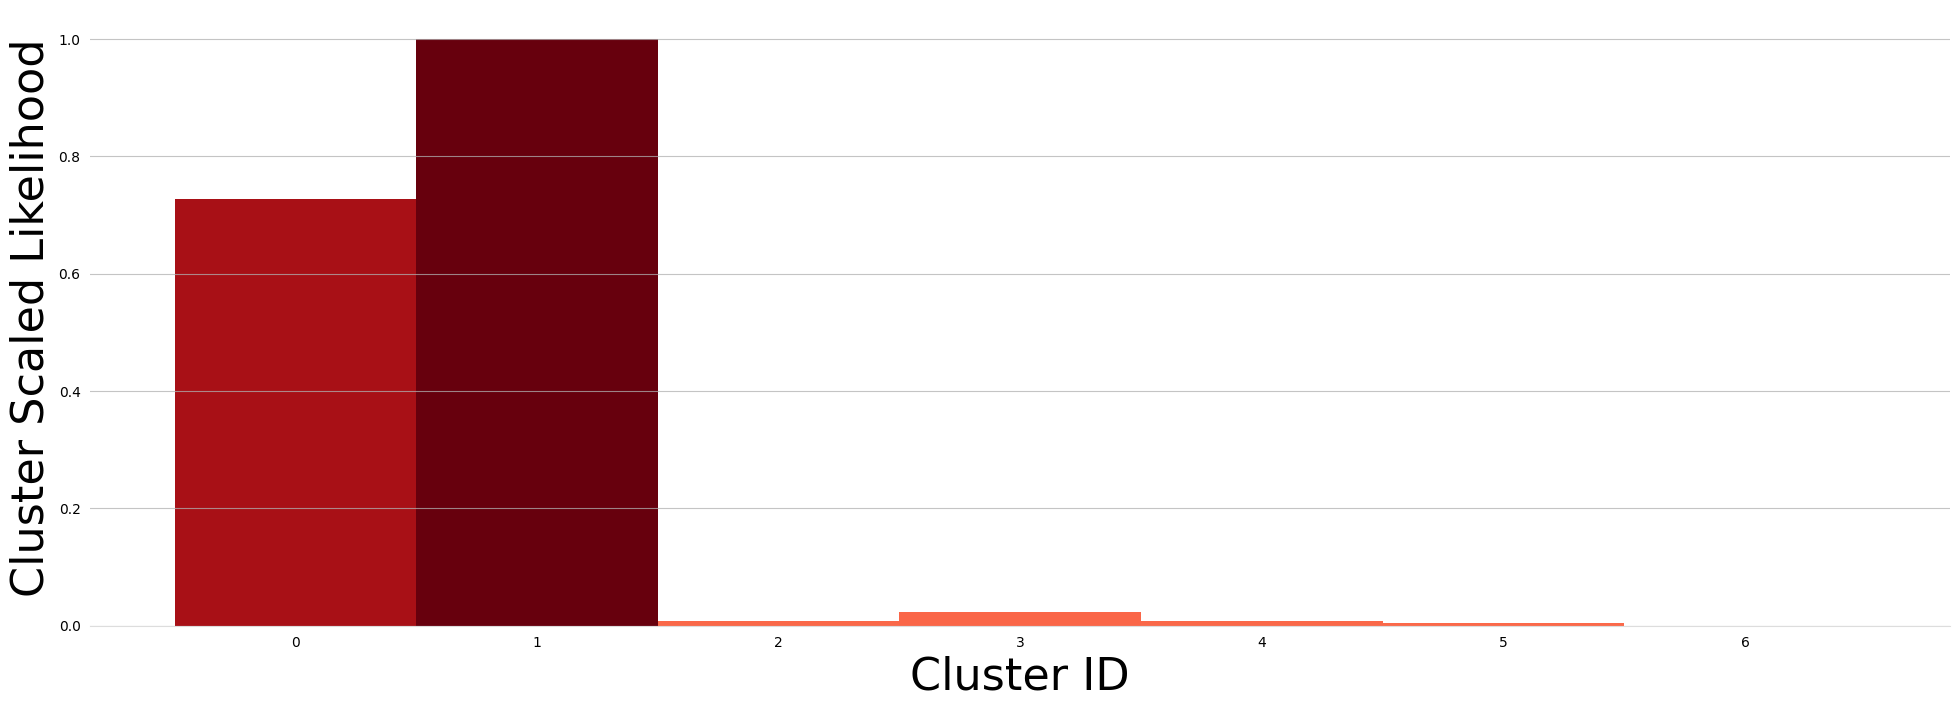

In [14]:
id_list, n_samples, sample_likelihood, sample_scaled_likelihood = \
    [], [], [], []
for i in range(len(np.unique(labels))):
    cluster_ids = np.array(train_tokens)[labels == i]
    id_list.append(i)
    n_samples.append(len(cluster_ids))
    sample_likelihood.append(len(cluster_ids) / len(dataset))
    sample_scaled_likelihood.append(len(cluster_ids) / largest_cluster_size)


# plot histogram
fig, ax = plt.subplots(figsize=(24, 8))
# color each bar based on its height and color as hue of red
colors = plt.cm.Reds(0.5 + np.array(n_samples) / (2 * np.max(n_samples)))
ax.bar(id_list, n_samples, width=1.0, color=colors)
ax.grid(axis='y', alpha=0.75)

ax.set_xlabel('Cluster ID', fontsize=32)
ax.set_ylabel('Number of Samples', fontsize=32)

# let's remove the top, right and left spines (figure borders)
# Also, make the bottom spine gray instead of black.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')

# remove the ticks as well.
ax.tick_params(bottom=False, left=False)
plt.show()

# plot cluster sample likelihood
fig, ax = plt.subplots(figsize=(24, 8))
# color each bar based on its height and color as hue of red
colors = plt.cm.Reds(0.5 + np.array(sample_likelihood) / (2 * np.max(sample_likelihood)))
ax.bar(id_list, sample_likelihood, width=1.0, color=colors)
ax.grid(axis='y', alpha=0.75)

ax.set_xlabel('Cluster ID', fontsize=32)
ax.set_ylabel('Cluster Likelihood', fontsize=32)

# let's remove the top, right and left spines (figure borders)
# Also, make the bottom spine gray instead of black.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')

# remove the ticks as well.
ax.tick_params(bottom=False, left=False)
plt.show()

# plot cluster sample likelihood
fig, ax = plt.subplots(figsize=(24, 8))
# color each bar based on its height and color as hue of red
colors = plt.cm.Reds(0.5 + np.array(sample_scaled_likelihood) / (2 * np.max(sample_scaled_likelihood)))
ax.bar(id_list, sample_scaled_likelihood, width=1.0, color=colors)
ax.grid(axis='y', alpha=0.75)

ax.set_xlabel('Cluster ID', fontsize=32)
ax.set_ylabel('Cluster Scaled Likelihood', fontsize=32)

# let's remove the top, right and left spines (figure borders)
# Also, make the bottom spine gray instead of black.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')

# remove the ticks as well.
ax.tick_params(bottom=False, left=False)
# plt.tight_layout()
plt.savefig(f'plots/{dataset_str}_dataset_likelihood.png')
plt.show()

### Show a few images from each cluster

Visualizing rarest clusters of dataset samples...


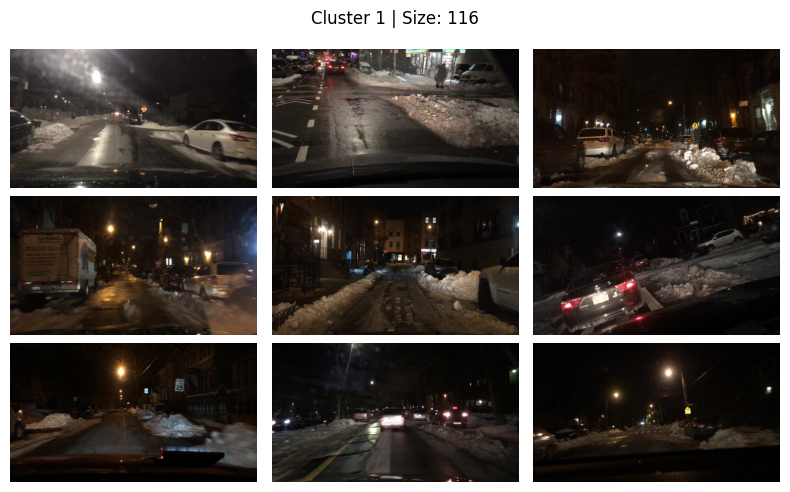

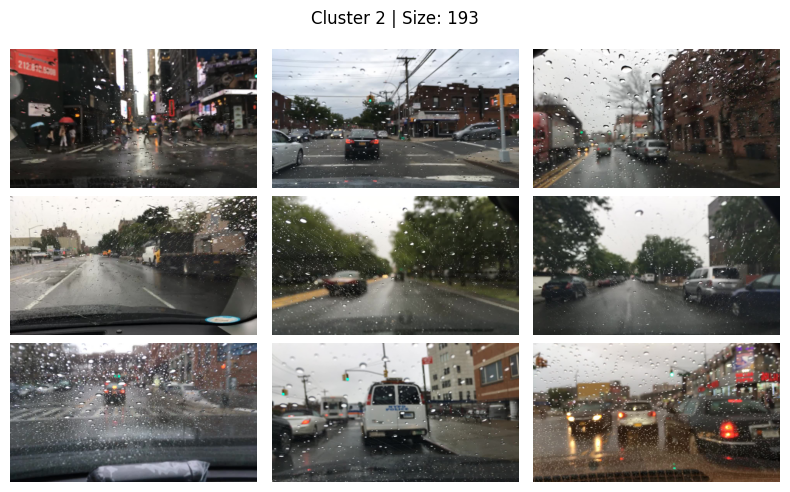

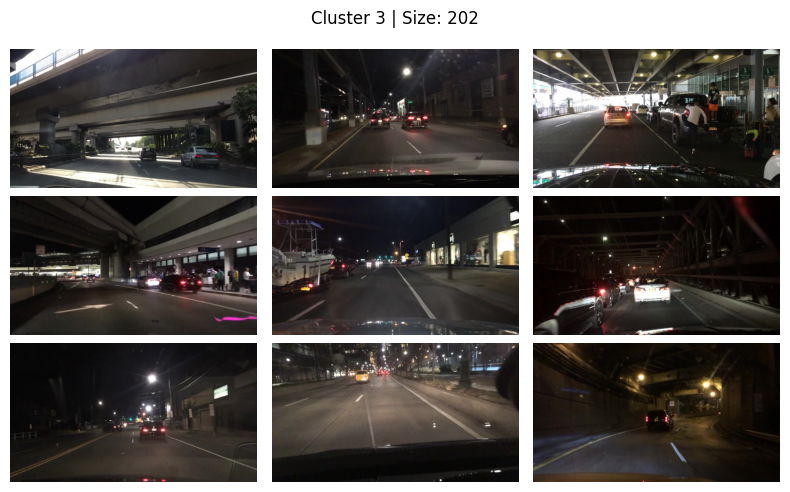

Visualizing most likely clusters of dataset samples...


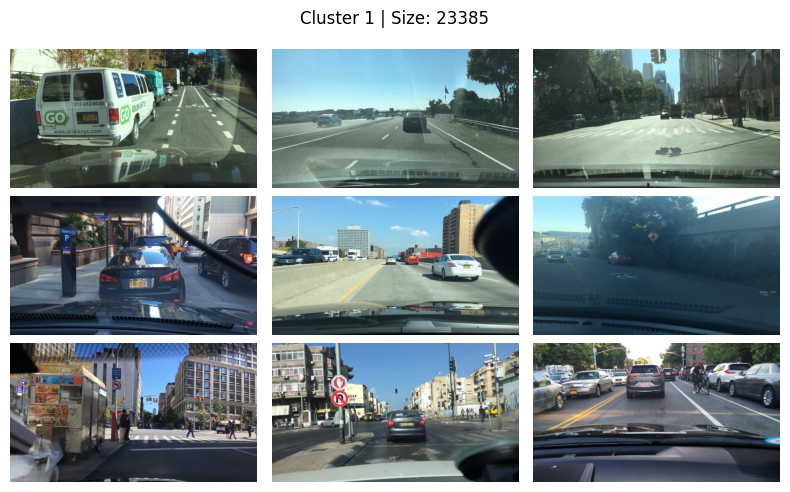

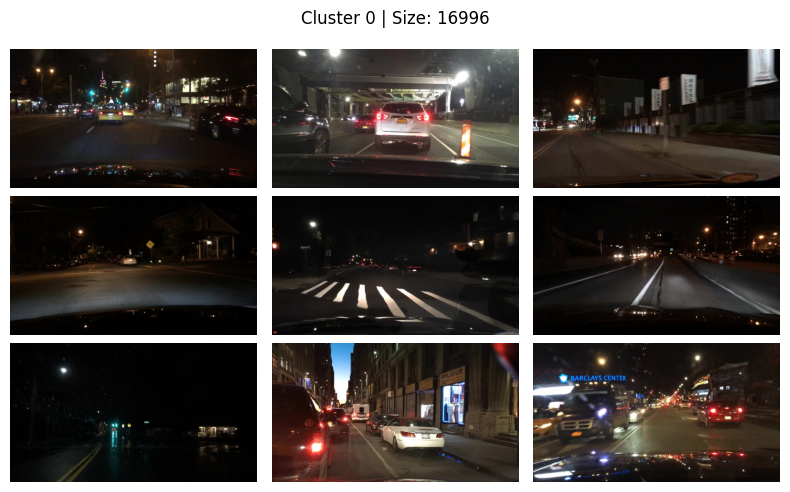

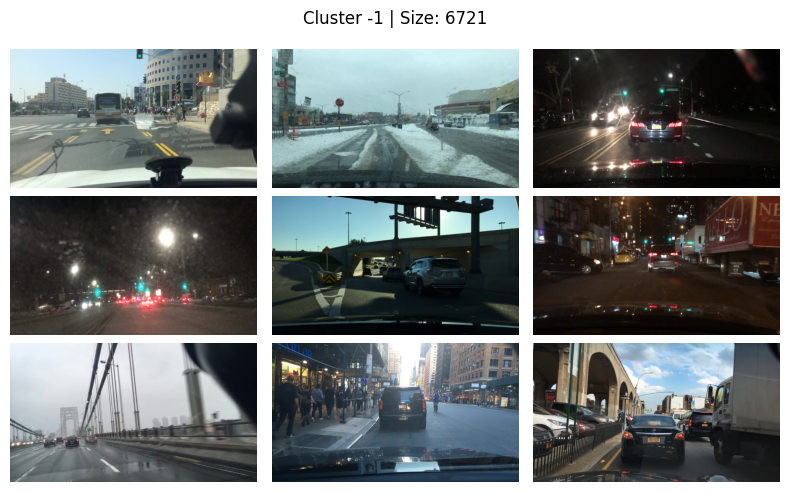

In [18]:
# show images from rarest clusters
n_clusters_to_visualize = 3
print('Visualizing rarest clusters of dataset samples...')
for i in range(min(n_clusters_to_visualize, len(unique_cluster_ids))):
    cluster_ids = np.array(train_tokens)[labels == unique_cluster_ids[i]]
    # randomize the order of the images
    np.random.shuffle(cluster_ids)
    # show 9 images for this cluster
    plt.figure(figsize=(8,5))
    plt.suptitle('Cluster {} | Size: {}'.format(
        i+1, train_dataset_cluster_info[cluster_ids[0]]['cluster_size']))
    for j in range(min(9, len(cluster_ids))):
        filename = os.path.join(dataroot, version, split, f"{cluster_ids[j]}.jpg")
        
        img = Image.open(filename)
        plt.subplot(3,3,j+1)
        plt.imshow(img)

        plt.axis('off')
    plt.tight_layout()
plt.show()

# show images from most likely clusters
n_clusters_to_visualize = 3
print('Visualizing most likely clusters of dataset samples...')
reversed_unique_cluster_ids = list(reversed(unique_cluster_ids))
for i in range(min(n_clusters_to_visualize, len(reversed_unique_cluster_ids))):
    cluster_ids = np.array(train_tokens)[labels == reversed_unique_cluster_ids[i]]
    # randomize the order of the images
    np.random.shuffle(cluster_ids)
    # show 9 images for this cluster
    plt.figure(figsize=(8,5))
    plt.suptitle('Cluster {} | Size: {}'.format(
        train_dataset_cluster_info[cluster_ids[j]]['cluster_id'], 
        train_dataset_cluster_info[cluster_ids[0]]['cluster_size']))
    for j in range(min(9, len(cluster_ids))):
        filename = os.path.join(dataroot, version, split, f"{cluster_ids[j]}.jpg")
        
        img = Image.open(filename)
        plt.subplot(3,3,j+1)
        plt.imshow(img)

        plt.axis('off')
    plt.tight_layout()
plt.show()